# Using AI models to predict EV charging from ACn Dataset:

## Data Preprocessing:

### Getting ACN dataset:

Initially, 5 months worth of ACN dataset between Jan 1st, 2019 to May 1st, 2019 is taken using the ACN python data client. The reason for selecting dataset from the year 2019 is to avoid having to deal with unpredictable user behaviour patterns following the outbreak of COVID-19 pandemic and its subsequent lockdowns.

Another important reason in selecting a reduced dataset is due to the difficulty in obtaining the peak current draw from the dataset (this difficulty is specific to me utilizing a fairly average performing MacBook Air laptop without any parallel computing). To obtain the peak current draw, we need to get the maximum value for a single session from the timseseries data (which maybe be well over 12000 values in many individual sessions) and to obatain max value from a list is a O(n) problem and cannot be optimized further and thus iterating over 32000(a year's worth of charging sessions) * 12000 (average number of timeseries values) = 382000000 values would take a lot of time.

Therefore, the final dataset used in my case is around 2052 sessions.

In [52]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from copy import deepcopy

from acnportal import algorithms
from acnportal import acnsim
import acnportal
import pandas as pd
import operator

# -- Dataset Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2019, 1, 1))
end = timezone.localize(datetime(2019, 5, 1))
period = 5  # minute
voltage = 220  # volts
default_battery_power = 32 * voltage / 1000 # kW
site = 'caltech'

API_TOKEN = "oBL14uoscrie7S2lK5appGQlnr12yUwe--ctzQnA_0o"
max_current = []
data = acnportal.acndata.DataClient(API_TOKEN)
data_sessions_with_timeseries = data.get_sessions_by_time(site,start=start, end=end,timeseries=True)
data_sessions = data.get_sessions_by_time(site,start=start, end=end)
Df = pd.DataFrame(data_sessions)

### Converting connectionTime(start time) and disconnectTime(end time) to datetime format:

In [62]:
Df['connectionTime'] = pd.to_datetime(Df['connectionTime'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')
Df['disconnectTime'] = pd.to_datetime(Df['disconnectTime'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

In [65]:
assert Df.connectionTime.isnull().sum() == 0, 'missing connectionTime dates'
assert Df.disconnectTime.isnull().sum() == 0, 'missing disconnectTime dates'

### Obtaining minute, hour, day, month, day of week for connectionTime(start time):

In [67]:
Df['connectionTime_year'] = Df['connectionTime'].dt.year
Df['connectionTime_month'] = Df['connectionTime'].dt.month
Df['connectionTime_week'] = Df['connectionTime'].dt.isocalendar().week
Df['connectionTime_day'] = Df['connectionTime'].dt.day
Df['connectionTime_hour'] = Df['connectionTime'].dt.hour
Df['connectionTime_minute'] = Df['connectionTime'].dt.minute
Df['connectionTime_dayofweek'] = Df['connectionTime'].dt.dayofweek

### Obtaining Peak Current Draw from timeseries data for each session:

In [135]:
for i in data_sessions_with_timeseries:
    print(i)
    if 'chargingCurrent' in i:
        if 'current' in i['chargingCurrent']:
            max_current.append(max(i['chargingCurrent']['current']))
            us.append(i['connectionTime'])
        else:
            max_current.append('None')
    else:
        max_current.append('None')
Df['max_current'] = max_current

### Obtaining session_length (charging time):

In [186]:
Df['session_length'] = Df['disconnectTime'] - Df['connectionTime']

/var/folders/7q/nxjkhqk91hqcpldmvtwmtzqc0000gn/T/ipykernel_99645/32091968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['session_length'] = Df['disconnectTime'] - Df['connectionTime']


In [185]:
Df['session_length'] = sess_len

/var/folders/7q/nxjkhqk91hqcpldmvtwmtzqc0000gn/T/ipykernel_99645/1348757950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['session_length'] = sess_len


### Saving Max current Data and obtaining ACN dataset:

In [80]:
import numpy as np
np.save('max_current.npy',np.array(max_current))

In [139]:
Df.to_pickle("ACN_Dataset")

In [187]:
Df

,_id,userInputs,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,...,userID,connectionTime_year,connectionTime_month,connectionTime_week,connectionTime_day,connectionTime_hour,connectionTime_minute,connectionTime_dayofweek,max_current,session_length
0,5c412c1df9af8b12cb56c27c,None,2_39_138_566_2019-01-01 17:41:44.784919,2-39-138-566,CA-512,0002,0039,2019-01-01 09:41:45-08:00,2019-01-01 10:39:21-08:00,0.900,...,None,2019,1,1,1,9,41,1,7.9,0 days 00:57:36
1,5c412c1df9af8b12cb56c27d,"[{'userID': 558, 'milesRequested': 80, 'WhPerM...",2_39_79_379_2019-01-01 18:09:16.991864,2-39-79-379,CA-327,0002,0039,2019-01-01 10:09:17-08:00,2019-01-01 18:39:32-08:00,12.534,...,000000558,2019,1,1,1,10,9,1,31.7,0 days 08:30:15
2,5c412c1df9af8b12cb56c27e,None,2_39_138_566_2019-01-01 18:39:24.566872,2-39-138-566,CA-512,0002,0039,2019-01-01 10:39:25-08:00,2019-01-01 11:18:49-08:00,0.883,...,None,2019,1,1,1,10,39,1,7.9,0 days 00:39:24
3,5c412c1df9af8b12cb56c27f,None,2_39_138_566_2019-01-01 19:18:52.843645,2-39-138-566,CA-512,0002,0039,2019-01-01 11:18:53-08:00,2019-01-01 12:14:07-08:00,0.879,...,None,2019,1,1,1,11,18,1,7.9,0 days 00:55:14
4,5c412c1df9af8b12cb56c280,"[{'userID': 1135, 'milesRequested': 50, 'WhPer...",2_39_79_378_2019-01-01 21:05:56.972890,2-39-79-378,CA-326,0002,0039,2019-01-01 13:05:57-08:00,2019-01-01 18:03:02-08:00,16.136,...,000001135,2019,1,1,1,13,5,1,16.1,0 days 04:57:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,5c942ca4f9af8b06b04b3bbb,"[{'userID': 838, 'milesRequested': 80, 'WhPerM...",2_39_129_17_2019-03-06 02:45:15.155199,2-39-129-17,CA-307,0002,0039,2019-03-05 18:45:15-08:00,2019-03-06 06:34:26-08:00,15.761,...,000000838,2019,3,10,5,18,45,1,16.2,0 days 11:49:11
2048,5c942ca4f9af8b06b04b3bbc,None,2_39_139_28_2019-03-06 03:11:43.821930,2-39-139-28,CA-303,0002,0039,2019-03-05 19:11:44-08:00,2019-03-05 20:11:38-08:00,0.884,...,None,2019,3,10,5,19,11,1,8.1,0 days 00:59:54
2049,5c942ca4f9af8b06b04b3bbd,"[{'userID': 1135, 'milesRequested': 50, 'WhPer...",2_39_126_20_2019-03-06 03:36:38.851835,2-39-126-20,CA-310,0002,0039,2019-03-05 19:36:39-08:00,2019-03-05 22:29:27-08:00,9.917,...,000001135,2019,3,10,5,19,36,1,16.1,0 days 02:52:48
2050,5c942ca4f9af8b06b04b3bbe,"[{'userID': 637, 'milesRequested': 140, 'WhPer...",2_39_123_23_2019-03-06 03:59:53.566560,2-39-123-23,CA-313,0002,0039,2019-03-05 19:59:54-08:00,2019-03-05 22:31:50-08:00,15.642,...,000000637,2019,3,10,5,19,59,1,31.8,0 days 02:31:56


## Data Exploration and Analysis:

### Plotting Number of Users Vs Day of the week:

<BarContainer object of 7 artists>

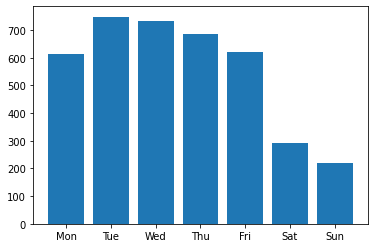

In [75]:
Days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.bar(Days,Df.groupby('connectionTime_dayofweek').size())

## Observation:

We notice that there are lesser sessions during the weekends which is expected due to the site used being a worksplace charging station (caltech)

### Plotting Number of Sessions Vs Month:

<BarContainer object of 4 artists>

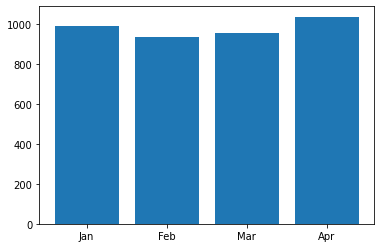

In [78]:
Months = ['Jan','Feb','Mar','Apr']#,'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(Months,Df.groupby('connectionTime_month').size())

## Observation:

We notice that the number of sessions are more or less the same for all the months utilized here. There is no singificant difference here.

### Plotting Number of Sessions (for start time) Vs Hours of the Day:

<BarContainer object of 24 artists>

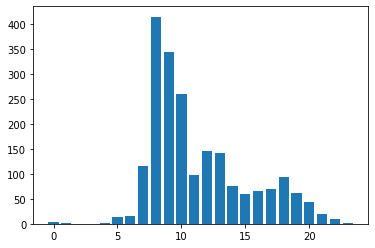

In [315]:
Hours = list(range(24))
Hheights = Df.groupby('connectionTime_hour').size().tolist()
Hheights.insert(2,0)
Hheights.insert(3,0)
plt.bar(Hours,Hheights)

## Observation:

We notice that the number of sessions are high for start times at the start of office hours (around 8 AM and 9 AM for Caltech) because this is primarily a workplace charging station.

### Plotting Number of Sessions (for end time) Vs Hours of the Day:

<BarContainer object of 24 artists>

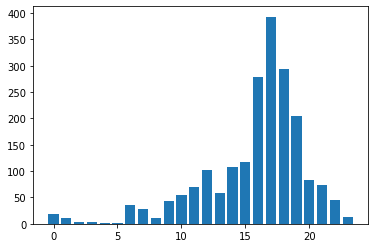

In [319]:
Hours = list(range(24))
Hheights = Df.groupby(Df['disconnectTime'].dt.hour).size().tolist()
plt.bar(Hours,Hheights)

## Observation:

We notice that the number of sessions are high for end times at the end of office hours (around 5PM and 6PM for Caltech) because this is primarily a workplace charging station.

## Feature Engineering:

In this part, we could possiblly isolate all the outlier datapoints using boxplots and isolation trees but because the dataset is already significantly reduced, this step is skipped.

We generate the X(features) and Y(target values) for the obtained dataset:

To generate X, we utilize only useful features which are time-related information and not IDs because the IDs are very inconsistent and make no significant difference when used as features.
Since, the only available features that we have are the hour, minutes, day of week, day, month, kWh delivered, we need to appropriately convert them into usable features.

All time related features like hours of the day are periodic in nature and can be appropriately converted into sin and cos component values instead of one hot encoding because it is more efficient that the sparse matrix that is generated as a result of one hot encoding. The kWh delivered is also approriately scaled into zero mean and unit variance.

Additionally, we add two columns that indicate whether the day is a weekend or holiday(using the calender of US federal holidays) and these columns take the value of 0 or 1.

In [241]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2019-01-01', end='2019-05-01').to_pydatetime()

def transformation(column):
    max_value = column.max()
    sin_values = [np.sin((2*np.pi*x)/max_value) for x in list(column)]
    cos_values = [np.cos((2*np.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values
def check_weekend(row):
    if row['connectionTime_dayofweek'] == 5 or row['connectionTime_dayofweek'] == 6:
        val = 1
    else:
        val = 0
    return val
def check_holiday(row):
    if row['connectionTime'] in holidays:
        val = 1
    else:
        val = 0
    return val

In [249]:
from sklearn import preprocessing
import numpy as np

X = pd.DataFrame()
X['day_of_week_sin'],X['day_of_week_cos'] = transformation(Df['connectionTime_dayofweek'])
X['day_sin'],X['day_cos'] = transformation(Df['connectionTime_day'])
X['hour_sin'],X['hour_cos'] = transformation(Df['connectionTime_hour'])
X['week_sin'],X['week_cos'] = transformation(Df['connectionTime_week'])
X['month_sin'],X['month_cos'] = transformation(Df['connectionTime_month'])
scaler = preprocessing.StandardScaler().fit(Df['kWhDelivered'].to_numpy().reshape(-1, 1))
X['kWh_delivered_scaled'] = scaler.transform(Df['kWhDelivered'].to_numpy().reshape(-1, 1))
X['is_weekend'] = Df.apply(check_weekend, axis=1)
X['is_holiday'] = Df.apply(check_holiday, axis=1)


In [320]:
X

,day_of_week_sin,day_of_week_cos,day_sin,day_cos,hour_sin,hour_cos,week_sin,week_cos,month_sin,month_cos,kWh_delivered_scaled,is_weekend,is_holiday
0,0.866025,0.5,0.201299,0.979530,0.631088,-0.775711,5.877853e-01,0.809017,8.660254e-01,-0.5,-0.907725,0,0
1,0.866025,0.5,0.201299,0.979530,0.398401,-0.917211,5.877853e-01,0.809017,8.660254e-01,-0.5,0.233463,0,0
2,0.866025,0.5,0.201299,0.979530,0.398401,-0.917211,5.877853e-01,0.809017,8.660254e-01,-0.5,-0.909392,0,0
3,0.866025,0.5,0.201299,0.979530,0.136167,-0.990686,5.877853e-01,0.809017,8.660254e-01,-0.5,-0.909785,0,0
4,0.866025,0.5,0.201299,0.979530,-0.398401,-0.917211,5.877853e-01,0.809017,8.660254e-01,-0.5,0.586786,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,0.866025,0.5,0.848644,0.528964,-0.979084,0.203456,-2.449294e-16,1.000000,-2.449294e-16,1.0,0.550002,0,0
2048,0.866025,0.5,0.848644,0.528964,-0.887885,0.460065,-2.449294e-16,1.000000,-2.449294e-16,1.0,-0.909294,0,0
2049,0.866025,0.5,0.848644,0.528964,-0.887885,0.460065,-2.449294e-16,1.000000,-2.449294e-16,1.0,-0.023241,0,0
2050,0.866025,0.5,0.848644,0.528964,-0.887885,0.460065,-2.449294e-16,1.000000,-2.449294e-16,1.0,0.538329,0,0


In [254]:
Y = pd.DataFrame()
Y['start_time'] = Df['connectionTime'].dt.hour + Df['connectionTime'].dt.minute/60 #+ Df['connectionTime'].dt.second/3600
Y['charging_time'] = Df['session_length'].dt.days*24 + Df['session_length'].dt.seconds//3600 + ((Df['session_length'].dt.seconds//60)%60)/60 #+ (Df['session_length'].dt.seconds%3600)/3600
Y['end_time'] = (Y['start_time'] + Y['charging_time'])%24
Y['peak_current_draw'] = Df['max_current']

In [230]:
Y

,start_time,charging_time,end_time,peak_current_draw
0,9.683333,0.950000,10.633333,7.9
1,10.150000,8.500000,18.650000,31.7
2,10.650000,0.650000,11.300000,7.9
3,11.300000,0.916667,12.216667,7.9
4,13.083333,4.950000,18.033333,16.1
...,...,...,...,...
2047,18.750000,11.816667,6.566667,16.2
2048,19.183333,0.983333,20.166667,8.1
2049,19.600000,2.866667,22.466667,16.1
2050,19.983333,2.516667,22.500000,31.8


## Applying Different ML Models for prediction:

To evaluate the different models used, we use SMAPE (Symmetric Mean Absolute Percentage Error) [shown as function] which is better than MAE because when there are values that are closer to 0, MAE gets skewed by those predictions. In, SMAPE, the values closer to 0 do not effect the error percentage due to the denominator of (y_pred + y)

k-fold validation and grid-search for best hyperparameters for the models were tested and did not make significant improvement due to reduced dataset.

In [338]:
import gc
gc.collect()

import numpy as np
import time

import matplotlib.pyplot as plt   
#from skimage.io import imshow

##Metrics
from sklearn.metrics import mean_squared_error

# Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb

In [351]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

ESTIMATORS = {
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=4, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=5)),
    "XGBoost" : MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))
}

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

y_test_predict = dict()
y_smape= dict()

print("SMAPE Errors (in %):")
print(" ")

for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)                    # fit() with instantiated object
    y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
    y_smape[name] = smape(y_test, estimator.predict(X_test))
    print(name)
    print(y_smape[name])
    print(" ")

#print(y_smape)

SMAPE Errors (in %):
 
K-nn
start_time            6.801975
charging_time        47.599370
end_time             18.385792
peak_current_draw    30.067359
dtype: float64
 
Linear regression
start_time            5.303635
charging_time        51.868247
end_time             18.548283
peak_current_draw    32.707072
dtype: float64
 
Ridge
start_time            5.233882
charging_time        51.950943
end_time             18.564963
peak_current_draw    32.737400
dtype: float64
 
Lasso
start_time           12.047200
charging_time        59.483073
end_time             19.746425
peak_current_draw    33.778549
dtype: float64
 
ElasticNet
start_time           17.014390
charging_time        58.611762
end_time             19.746425
peak_current_draw    35.140524
dtype: float64
 
RandomForestRegressor
start_time            8.936638
charging_time        47.181481
end_time             17.543183
peak_current_draw    21.417945
dtype: float64
 
Decision Tree Regressor
start_time           10.001306
charging

## Observation and Potential for Improvement:

For the various multioutput regressor models used, we can see that most models give error values that are close in range to each other.

But the most noticeable value is the start time which can be predicted with significantly high accuracy(close to 2% error for some of the models). This is because the utilized features are perfect (time related details) for predicting when a session will start because of general human workforce behaviour (ie: most working people follow a reasonable pattern of arriving at predictable times to their workplace).

Similarly, the end times can also be predicted with resonable accuracy of around 16~19%. Although, the exact end time cannot be predicted due to various reasons such as - car not yet charged, other work delays, unexpected emergencies unique to the user, etc, the error values are resonable but they can be made even more accurate when the time series data of each session is also utilized (by predicting the number of actively charging cars and the rate at which the user's car will finish charging).

Meanwhile, the charging time calculation will definitely require more features as is apparent with the high error values above. The charging time can be decided with the rate of charging and active load of the station and number of stations occupied - all of which require the time series data.

Finally, the peakcurrent draw could potentially improve with time series data but the factor of improvement cannot be predicted until it is implemented.

### The reason for not using the timeseries data is quite simply the limitations of my current available hardware as mentioned at the start of this notebook

Additionally, other factors such as traffic, weather conditions (such as rain, etc) around the Caltech campus during the time period may prove useful in improving the accuracies of the prediction (which are available through google maps, etc)